# Project- Recommendation Systems: Amazon product reviews


----------------
### Objective:
----------------

Build a recommendation system to recommend products to customers based on their previous ratings for other products.

--------------
### Dataset:
--------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** Rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating (ignore this column for this exercise)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 5.5 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630192 sha256=2a730927331c4c312a60b57b9af9b3f1cdce39d637fa26a6a569ca4cb993336f
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


### Importing Libraries

In [ ]:
import numpy as np # Basic libraries of python for numeric and dataframe computations.
import pandas as pd

import matplotlib.pyplot as plt #Basic library for data visualization.
import seaborn as sns #Slightly advanced library for data visualization

# from sklearn.metrics.pairwise import cosine_similarity #To compute the cosine similarity between two vectors.
from collections import defaultdict #A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error # A performance metrics in sklearn.

### Loading data

In [ ]:
#Import the data set
df = pd.read_csv('/content/drive/MyDrive/ratings_Electronics.csv', header=None) #There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

**As this dataset is very large and has 78,24,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence we can reduce the dataset by considering certain Logical assumptions.**

Here, We will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considred
RATINGS_CUTOFF = 50
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df = df.loc[~df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the users
users = df.prod_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considred
RATINGS_CUTOFF = 5
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df_final = df.loc[~df.prod_id.isin(remove_users)]

In [ ]:
# see a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


### Exploratory Data Analysis (6 marks)

**Please fill in the blanks and complete the code(and provide observations) for the following cells wherever mentioned.**

#### Shape of the data

In [ ]:
# Check the number of rows and columns and provide observations
rows, columns = df_final.shape
print("No of rows: ", rows)
print("No of columns: ", columns)

No of rows:  65290
No of columns:  3




There are 65290 instances (rows) and 3 categories, user ID product ID and rating.



#### Data types

In [ ]:
#Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB



- User_id is a non-null with data type object
- Product_id is a object data type
- Rating are of float data type.



#### Checking for missing values

In [ ]:
# Check for missing values present and provide observations
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

- There are no missing values for the user_id, prod_id or rating categories.

#### Summary Statistics

In [ ]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe()

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**Obervations:______**
- The mean number for the ratings is 4.29
- Minimum rating is 1.0, this makes sense given the rating system 1-5 stars
- The Median rating is 5.0, this means that most ratings are favourable rated at 5.0 and tells us that the data is skewed given it is greater than the mean.


#### Checking the rating distribution

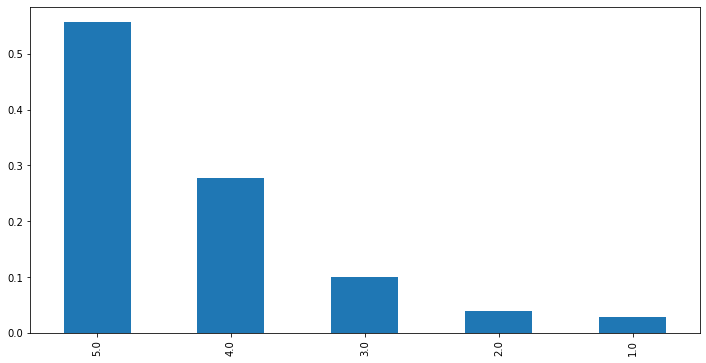

In [ ]:
#Create the bar plot and provide observations

plt.figure(figsize = (12,6))
df_final['rating'].value_counts(1).plot(kind='bar')
plt.show()

- The majority of ratings are 5.0. This is confirmed from our earlier summaries of the data.
- There are almost half the amount of 4.0 ratings.
- The decending order of ratings are trending to the number of ratings for each. 5 stars have the most, while 1 star has the least.

#### Checking the number of unique users and items in the dataset

In [ ]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df_final['prod_id'].nunique())

Number of unique USERS in Raw data =  1540
Number of unique ITEMS in Raw data =  5689


- There are **1540 unique users and 5689 products** in the dataset

#### Users with most number of ratings

In [ ]:
# Top 10 users based on rating
most_rated = df_final.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64

- The highest number of **ratings by a user is 295** which is far from the actual number of products present in the data. We can build a recommendation system to recommend products to users which they have not interacted with.

### Data preparation  (2 Marks)

In [ ]:
#Check the number of unique USERS and PRODUCTS in the final data and provide observations

print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 65290
Number of unique USERS in the final data =  1540
Number of unique PRODUCTS in the final data =  5689


- There 65290 observations in the final data set.
- There are 1540 unique users, thus users have multiple ratings for multiple prodcuts.
- There are 5689 unique products, products have been rated more than once by more than one user.



Now that we have explored and preprocessed the data, let's build the first recommendation system

### Rank Based Recommendation System (10 marks)

In [ ]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [ ]:
#Calculate the average rating for each product
average_rating = df_final.groupby('prod_id').mean()['rating']

#Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id').count()['rating']

#Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

#Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by='avg_rating', ascending=False)

final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [ ]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):

    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]

    #Sorting values w.r.t average rating
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)

    return recommendations.index[:n]

#### Recommending top 5 products with 50 minimum interactions based on popularity

In [ ]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

#### Recommending top 5 products with 100 minimum interactions based on popularity

In [ ]:
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using collaborative filtering

### Collaborative Filtering Based Recommendation System

#### Types of Collaborative Filtering

- Similarity/Neighborhood based
 * User User Similarity Based  
 * Item Item similarity based
- Model based

#### Building a baseline user user similarity based recommendation system

- Below we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library - `surprise` to build the remaining models, let's first import the necessary classes and functions from this library

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# class for loading datasets
from surprise.dataset import Dataset

# for tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# for splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# for implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# for implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing KFold cross-validation
from surprise.model_selection import KFold

#For implementing clustering-based recommendation system
from surprise import CoClustering

- Below function takes the **recommendation model** as input and gives the **precision@k and recall@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.

In [ ]:
def precision_recall_at_k(model, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)

    #Making predictions on the test data
    predictions=model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    #Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)),3)
    #Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)),3)

    accuracy.rmse(predictions)
    print('Precision: ', precision) #Command to print the overall precision
    print('Recall: ', recall) #Command to print the overall recall
    print('F_1 score: ', round((2*precision*recall)/(precision+recall),3)) # Formula to compute the F-1 score.

Below we are loading the **`rating` dataset**, which is a **pandas dataframe**, into a **different format called `surprise.dataset.DatasetAutoFolds`** which is required by this library. To do this we will be **using the classes `Reader` and `Dataset`**

In [ ]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [ ]:
# instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

- Now we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.
- **KNNBasic** is an algorithm that is also **associated with the surprise package**, it is used to find the **desired similar items among a given set of items**.

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 is taken for the recommended and relevant ratings**.
- In the **present case precision and recall both need to be optimized as the service provider would like to minimize both the losses discussed** above. Hence, the correct performance measure is the **F_1 score**.

In [ ]:
#Declaring the similarity options.
sim_options = {'name': 'cosine',
               'user_based': True}

#Initialize the KNNBasic model using sim_options provided, Verbose=False, and setting random_state=1
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score
precision_recall_at_k(sim_user_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


- We calculated the RMSE of the ratings compared to the acutal ratings.
- Recall is high at .85 which means that .85 of the products are reccomended.
- Precision is .85 which also suggests that .85 of these products are relevant

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466'.

In [ ]:
#predicting rating for a sample user with an interacted product.
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
df_final[df_final.prod_id=="1400501466"].user_id.unique()

array(['A3LDPF5FMB782Z', 'A1A5KUIIIHFF4U', 'A2XIOXRRYX0KZY',
       'AW3LX47IHPFRL', 'A1E3OB6QMBKRYZ', 'A19N3S7CBSU6O7'], dtype=object)

* It can be observed from the **above list that user "A34BZM6S9L7QI4" has not seen a product with productId "1400501466"**.

Below we are **predicting rating for the same `userId=A34BZM6S9L7QI4` but for a product which this user has not seen yet i.e. `prod_id=1400501466`**

In [ ]:
#predicting rating for a sample user with a non interacted product.
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

#### Improving similarity-based recommendation system by tuning its hyper-parameters

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# fitting the data
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9718128175373479
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters** as shown above

Now let's build the **final model by using tuned values of the hyperparameters** which we received by using **grid search cross-validation**

In [ ]:
# using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, k=40, min_k=6, random_state=1, verbose=False)

# training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10.
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9526
Precision:  0.847
Recall:  0.894
F_1 score:  0.87


- We can see from above that after tuning hyperparameters, **F_1 score of the tuned model is slightly better than the baseline model**. Along with this **the RMSE of the model has gone down as compared to the model before hyperparameter tuning**. Hence, we can say that the model performance has improved slightly after hyperparameter tuning.

In [ ]:
#Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466.
sim_user_user_optimized.predict("A3LDPF5FMB782Z", 1400501466, r_ui=5.0, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5.0, est=4.292024046561495, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [ ]:
#Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict("A34BZM6S9L7QI4", 1400501466, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

- The above functions have compared two users to the same item '1400501466'. After hyper training, the model performs better for predicting user 'A3LDPF5FMB782Z', est a score of 4.29 compared to the earlier 3.4 with an acutal rating of 5.
- THe optimized model performs the same on the user with no interaction. 4.2 est score.

## Identifying similar users to a given user (nearest neighbors)

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric

In [ ]:
sim_user_user_optimized.get_neighbors(0,5) #Here 0 is the inner id of the above user.

[6, 7, 17, 26, 32]

#### Implementing the recommendation algorithm based on optimized KNNBasic model

Below we will be implementing a function where the input parameters are -

- data: a **rating** dataset
- user_id: a user id **against which we want the recommendations**
- top_n: the **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # creating an empty list to store the recommended product ids
    recommendations = []

    # creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index='user_id', columns='prod_id', values='rating')

    # extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # appending the predicted ratings
        recommendations.append((item_id, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating products for this user

#### Predicted top 5 products for userId="A3LDPF5FMB782Z" with similarity based recommendation system

In [ ]:
#Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)

In [ ]:
#Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B000BQ7GW8,5
2,B001TH7GUU,5
3,B005ES0YYA,5
4,B00834SJSK,5


### Correcting the Ratings and Ranking the above products

While comparing the ratings of two products, it is not only the **ratings** that describe the **likelihood of the user to that product**. Along with the rating the **number of users who have seen that product** also becomes important to consider. Due to this, we have calculated the **"corrected_ratings"** for each product. Commonly higher the **"rating_count" of a product more it is liked by users**. To interpret the above concept, a **product rated 4 with rating_count 3 is less liked in comparison to a product rated 3 with a rating count of 50**. It has been **empirically found that the likelihood of the product is directly proportional to the inverse of the square root of the rating_count of the product**.

In [ ]:
def ranking_products(recommendations, final_rating):
  # sort the products based on ratings count
  ranked_products = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending=False)[['rating_count']].reset_index()

  # merge with the recommended products to get predicted ratings
  ranked_products = ranked_products.merge(pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings']), on='prod_id', how='inner')

  # rank the products based on corrected ratings
  ranked_products['corrected_ratings'] = ranked_products['predicted_ratings'] - 1 / np.sqrt(ranked_products['rating_count'])

  # sort the products based on corrected ratings
  ranked_products = ranked_products.sort_values('corrected_ratings', ascending=False)

  return ranked_products

**Note:** In the **above-corrected rating formula**, we can add the **quantity `1/np.sqrt(n)` instead of subtracting it to get more optimistic predictions**. But here we are **subtracting this quantity**, as there are some products with ratings 5 and **we can't have a rating more than 5 for a product**.

In [ ]:
#Applying the ranking products function and sorting it based on corrected ratings.
ranking_products(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B00834SJSK,101,5,4.900496
1,B001TH7GUU,78,5,4.886772
2,B000BQ7GW8,54,5,4.863917
3,B000067RT6,41,5,4.843826
4,B005ES0YYA,26,5,4.803884


### Item Item Similarity-based collaborative filtering recommendation systems

* Above we have seen **similarity-based collaborative filtering** where similarity has seen **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
#Declaring the similarity options.
sim_options = {'name': 'cosine',
               'user_based': False}

#KNN algorithm is used to find desired similar items.
sim_item_item = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k =10.
precision_recall_at_k(sim_item_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


- The baseline model is giving a good F_1 score of ~84%. We will try to **improve this later by using GridSearchCV** by tuning different hyperparameters of this algorithm.

Let's now **predict a rating for a user with `userId=A3LDPF5FMB782Z` and `prod_Id=1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
#predicting rating for a sample user with an interacted product.
sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

Below we are **predicting rating for the same `userId=A34BZM6S9L7QI4` but for a product which this user has not interacted yet i.e. `prod_id=1400501466`**

In [ ]:
#predicting rating for a sample user with a non interacted product.
sim_item_item.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

#### Improving similarity-based recommendation system by tuning its hyper-parameters

### Hyperparameter tuning the item-item similarity-based model
- Use the following values for the param_grid and tune the model 
  - 'k':[10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure 
- Print the best score and best parameters 

In [ ]:
# setting up parameter grid to tune the hyperparameters
param_grid = {'k':[10,20,30], 'min_k':[3,6,9], 'sims_options':{'name':['msd', 'cosine'], 'user_based':[False]}}

# performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'])

# fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation

Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model. (5 Marks)

In [ ]:
# using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name':'msd' , 'user_based':[False]}

# creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options=sim_options , k=30 , min_k=6 , random_state=1, verbose=False)

# training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score@k and RMSE
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9530
Precision:  0.847
Recall:  0.893
F_1 score:  0.869



- There is a decrease in RMSE, however there is an increase in F_1 score compared to the base line model. This model peformed better after hypertraining to the tuned values.

Let's us now predict **rating for an user with `userId=A3LDPF5FMB782Z` and for `prod_id=1400501466`** with the **optimized model** as shown below

In [ ]:
sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

Below we are **predicting rating** for the same **`userId=A34BZM6S9L7QI4`** but for a product which this user **has not interacted before** i.e. `prod_id==1400501466`, by using the optimized model as shown below -

In [ ]:
sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

#### Identifying similar users to a given user (nearest neighbors)

We can also find out **similar users** to a given user or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding 5 most similar users to the user with internal id 0 based on the `msd` distance metric

In [ ]:
sim_item_item_optimized.get_neighbors(0, k=5)

[6, 42, 44, 54, 66]

#### Predicted top 5 products for userId="A1A5KUIIIHFF4U" with similarity based recommendation system

In [ ]:
#Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [ ]:
#Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5.000000
1,B001TH7GUU,5.000000
2,B000N99BBC,4.950105
3,B003ES5ZUU,4.927350
4,B002QEBMAK,4.910053


In [ ]:
#Applying the ranking products function and sorting it based on corrected ratings.
ranking_products(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
2,B001TH7GUU,78,5.000000,4.886772
1,B000N99BBC,167,4.950105,4.872723
0,B003ES5ZUU,184,4.927350,4.853629
4,B000067RT6,41,5.000000,4.843826
3,B002QEBMAK,60,4.910053,4.780953


* Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### Model Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

#### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

### Question: Build the matrix factorization recommendation system (using random_state=1) and provide your observations on performance of the model (4 Marks)

In [ ]:
# using SVD matrix factorization
svd = SVD(random_state=1)

# training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score@k, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866



- The F_1 score is lower compared to the F_1 score obtained from the KNN hyper trained reccomendation system.
- Precision is better performed on this model in comparision, while RMSE and Recall performed worse.

- Let's now predict the rating for a user with `userId="A3LDPF5FMB782Z"` and `prod_id="1400501466` as shown below
- Here the user has already rated the product.

In [ ]:
#Making prediction.
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

Below we are predicting rating for the same `userId=A34BZM6S9L7QI4` but for a product which this user has not interacted before i.e. `productId=1400501466`, as shown below -

In [ ]:
#Making prediction.
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

#### Improving matrix factorization based recommendation system by tuning its hyper-parameters

Below we will be tuning only three hyperparameters -
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

In [ ]:
# set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# performing 3-fold gridsearch cross validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# fitting data
gs_.fit(data)

# best RMSE score
print(gs_.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8978035431035783
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Once the **grid search** is complete, we can get the **optimal values** for each of those hyperparameters as shown above

Now we will **the build final model** by using **tuned values** of the hyperparameters which we received by using grid search cross-validation

### Fit the SVD model using the hyperparameters from GridSearchCV (use random_state=1) and compare the output with the baseline model (5 Marks)

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search
svd_optimized = SVD(n_epochs=2, lr_all= 0.01, reg_all=0.2, random_state=1)

# Train the algorithm on the trainset
svd_optimized=svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score@k, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.9163
Precision:  0.848
Recall:  0.901
F_1 score:  0.874


- The F1_score has improved to .87
- RMSE and recall has also improved.
- Overall, after tuning the hyper perameters the model has improved.


Let's now predict a rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466` with the optimized model as shown below

### Question:
- Using the optimized svd model, predict rating for the user with `userId`="A3LDPF5FMB782Z", and `prod_id`= 1400501466 (1 Mark)
- Predict rating for the same userId="A34BZM6S9L7QI4" but for a product which this user has not interacted before i.e. prod_id = 1400501466, by using the optimized model (1 Mark)
- Compare the output with the output from the baseline model (2 Marks)

In [ ]:
#Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466.
svd_optimized.predict("A3LDPF5FMB782Z", 1400501466,  r_ui=5, verbose=True )

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.28   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.277083824679155, details={'was_impossible': False})

In [ ]:
#Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.50   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.498535418578581, details={'was_impossible': False})

**Observations:**_____________

- The optimized model is closer to actual rating when predicting the rating compared to the base model for user A3LDPF5FMB782Z .
- The optimized model suggests a higher estimated rating, for the user that has not interacted with the product ID before.





In [ ]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


- Get 5 recommendations for the user with user_id = 'A2XIOXRRYX0KZY' using the svd_optimized model. Hint: Use get_recommendations() function (2 Marks)
- Rank the recommendations  on the basis of the correct ratings. Hint: Use ranking_products() function (2 Marks)

In [ ]:
#Get top 5 recommendations for user_id A2XIOXRRYX0KZY using "svd_optimized" algorithm.
svd_recommendations = get_recommendations(df_final, 'A2XIOXRRYX0KZY', 5, svd_optimized)

In [ ]:
#Ranking products based on above recommendations
ranking_products(svd_recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B000N99BBC,167,4.729127,4.651744
2,B0019EHU8G,90,4.714053,4.608644
1,B007WTAJTO,164,4.604980,4.526894
3,B002V8C3W2,46,4.642626,4.495184
4,B00BQ4F9ZA,45,4.615506,4.466435


### Conclusion
- In this case study, we built reccomenxdation systems based on:
Rank-based using averages,
User-user-similarity based collaborative filtering
item-item silimilarity based collaboritve filtering
Matrix factorization collaborative filtering

Surprise library was used, and grid search corss validation was used to find the optimal hyper pearameters for the data.

- F_1 Scores for each model was cacluated and evaluated, the optimized matrix factorizing model has given the best performance in F_1 scores.
- Futher Hyper tuning can be used to improve the performance of the models.